
# Dialect classification

### Install and import necessary packages

In [ ]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import datasets
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load data

#### import data

In [ ]:
torch.cuda.is_available()
device = torch.device("cuda")
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive'
train_path = '/content/drive/MyDrive/train_data.csv'
dev_path = '/content/drive/MyDrive/test_data.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 checkpoint-3000       predictions2	       test_data.txt
 checkpoint-3000.zip   predictions3	       test_features.csv
'Colab Notebooks'      pretrain_features.csv   train_data.csv
 predictions	       pretrain_labels.csv     train_features.csv
 predictions1	       submission.csv	       train_labels.csv


In [ ]:
#IMPORT devset
dial_label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

fold_label = {
    'EML' : 0,
    'NAP' : 1,
    'PMS' : 2,
    'FUR' : 3,
    'LLD' : 4,
    'LIJ' : 5,
    'LMO' : 6,
    'ROA_TARA' : 7,
    'SCN' : 8,
    'VEC' : 9,
    'SC' : 10
}

def explain_label(label : int) -> str:
    """ 
    Given an integer label, convert it to the corresponding string label
    :param int label: integer label to be converted
    :return: string corresponding to the given label
    """
    return dial_label[label]

def encode_label(label : str) -> int:
    """ 
    Given a string label, encode it to the corresponding index
    :param string label: string label to be converted
    :return: int corresponding to the given label
    """
    return fold_label[label]

In [ ]:
df_dev = pd.read_csv(dev_path, sep = "\t", names=["label", "text"])
df_dev['label'] = df_dev['label'].apply(encode_label)
df_dev = df_dev.fillna('')
#-
#df_train = pd.read_csv(train_path)
#df_train_=df_train[['text','label']]
#df_train_.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
#SUBSET
#f_train_ = df_train_.iloc[0:1000,:] 

In [ ]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'EML', 1: 'NAP', 2: 'PMS', 3: 'FUR', 4: 'LLD', 5: 'LIJ', 6: 'LMO', 7: 'ROA_TARA', 8: 'SCN', 9: 'VEC', 10: 'SC'}


In [ ]:
from datasets import Dataset
#train_ds = Dataset.from_pandas(df_train_)
dev_ds = Dataset.from_pandas(df_dev)
# Example of instance of the dataset
#train_ds[18]

## Tokenizing data

In [ ]:
# Load XLNet tokenizer.
model_name = 'drive/MyDrive/checkpoint-3000/'
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)

In [ ]:
def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['text'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=50)
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['label']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [ ]:
# Tokenizing datasets
#encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_test = encode_dataset(dev_ds)

## Data EDA

# Fine tunning of the model

In [ ]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/',
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

'''
# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()
'''

'\n# Create trainer\ntrainer = Trainer(\n    model=model,\n    tokenizer=tokenizer,\n    args=training_args,\n    train_dataset=encoded_dataset_train,)\n\n# Fine tunning\ntrainer.train()\n'

In [ ]:
from tqdm import tqdm

sentences = df_dev["text"].values.tolist()
cls_embeddings = []
with torch.no_grad():
  for sentence in tqdm(sentences):
    input = tokenizer(sentence, return_tensors="pt", padding='max_length', truncation=True, max_length=50).to(device)
    output = model(**input, output_hidden_states=True)
    last_hidden_states = output.hidden_states[-1][0, 0, :]
    cls_embeddings.append(last_hidden_states.to("cpu").numpy())

100%|██████████| 6801/6801 [01:19<00:00, 85.23it/s]


In [ ]:
from sklearn.manifold import TSNE

tnse = TSNE(n_components=2, n_iter=3000, metric='cosine', n_jobs=-1, init='random', learning_rate='auto', square_distances='legacy')
cls_tsne = tnse.fit_transform(np.array(cls_embeddings))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


Text(0.5, 1.0, '')

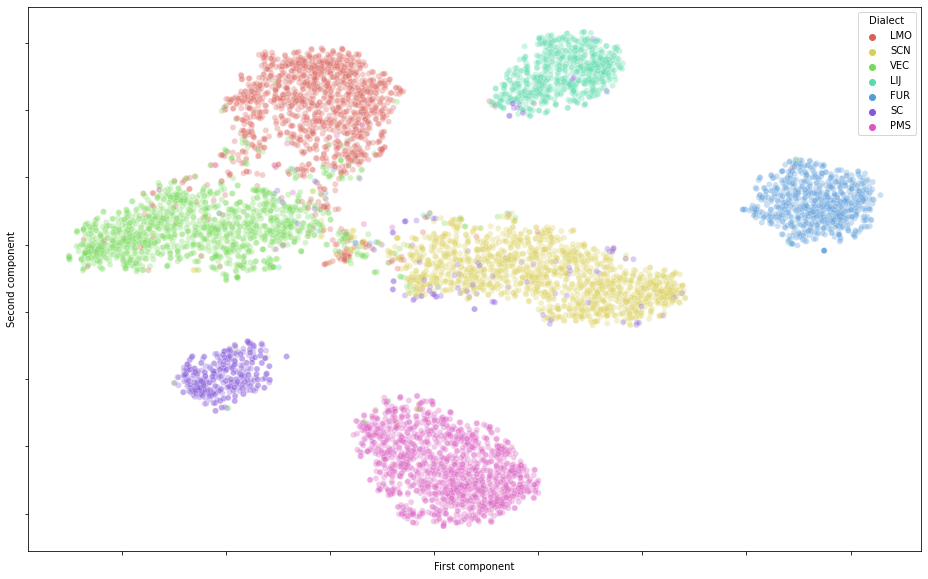

In [ ]:
import seaborn as sns
sns.axes_style("whitegrid")

df = pd.DataFrame()
df['tsne-2d-one'] = cls_tsne[:,0]
df['tsne-2d-two'] = cls_tsne[:,1]
df['Dialect'] = df_dev["label"]
df['Dialect'] = df['Dialect'].apply(explain_label)

fig = plt.figure(figsize = (16,10))

targets = ['EML', 'NAP', 'PMS', 'FUR', 'LLD', 'LIJ', 'LMO', 'ROA_TARA', 'SCN', 'VEC','SC']

ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Dialect",
    palette=sns.color_palette("hls", 7),
    data=df,
    legend=targets,
    alpha=0.3    
)

ax.grid(False)
ax.set(xticklabels=[], yticklabels=[])
ax.set(xlabel='First component', ylabel='Second component')
ax.set_title(label='')

In [ ]:
# Get the predicted labels
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)
#pred1 = pd.read_csv("drive/MyDrive/predictions1").to_numpy()
#pred2 = pd.read_csv("drive/MyDrive/predictions2").to_numpy()
#pred3 = pd.read_csv("drive/MyDrive/predictions3").to_numpy()
#predictions = np.hstack((pred1, pred2, pred3))
#predictions = np.median(predictions, axis = 1)

# Create array with predicted labels and expected.
true_values = np.array(preds.label_ids).flatten()
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

NameError: ignored

In [ ]:
pd.DataFrame(proc_predicted_values).to_csv("drive/MyDrive/predictions", header=False, index=False)

In [ ]:
wrong = []
for i,x in enumerate(df_dev["text"]):
  if df_dev["label"].iloc[i] != proc_predicted_values[i]:
    wrong.append(i)

In [ ]:
pd.DataFrame(wrong).to_csv("drive/MyDrive/wrong.csv", index=False, header=False)

# Models evaluation

F1-micro and F1-macro for each model

In [ ]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.8769298632554036
  f1-micro: 0.8769298632554036
  f1-macro: 0.5627176804812641



To understan better the performance of the classifier, we display the confusion matrix:

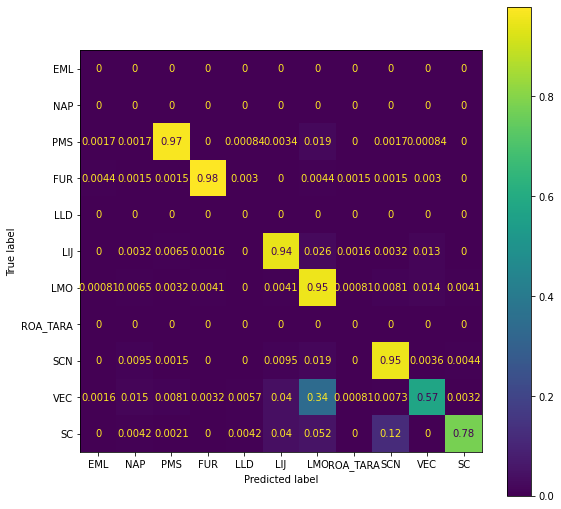

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'], display_labels = list(id2label.values()))
fig, ax = plt.subplots(figsize=(9,9))
disp.plot(ax=ax)

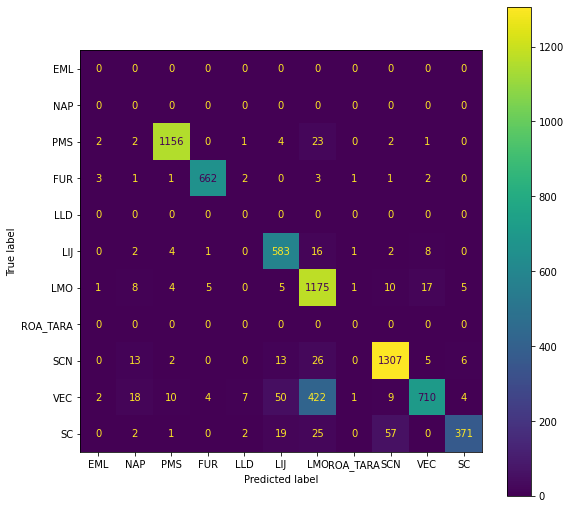

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
fig, ax = plt.subplots(figsize=(9,9))
disp.plot(ax=ax)

In [ ]:
np.array(df_dev["label"])

array([6, 8, 6, ..., 8, 8, 8])

In [ ]:
np.array(pd.read_csv("drive/MyDrive/predictions"))

array([[8],
       [6],
       [9],
       ...,
       [8],
       [8],
       [8]])

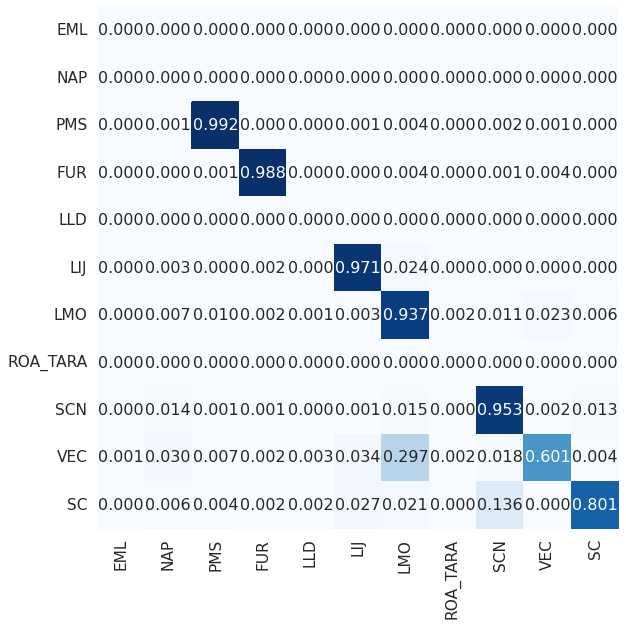

In [ ]:
cm = confusion_matrix(y_true=np.array(df_dev["label"])[1:], y_pred=np.array(pd.read_csv("drive/MyDrive/predictions")), normalize="true", labels=range(0,11))

df_cm = pd.DataFrame(cm, index = [explain_label(i) for i in range(0,11)],
                  columns = [explain_label(i) for i in range(0,11)])

plt.figure(figsize = (9, 9))
sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, 
            annot=True, 
            annot_kws={"size": 16}, 
            fmt='.3f', 
            cmap="Blues",
            cbar=False) 
plt.tight_layout()  

# plt.savefig('confusion.pdf')
plt.show()

